# Final Project:   MIR Genre Predictor

In this project, we will use song datasets to train two classifiers. The first model, a Multinomial Naive Bayes classifier, will be trained on a dataset containing song titles, artists, genres, release years, and lyrics. The second model will use decision trees, and it will be trained on a dataset containing the song titles and genres from the first dataset, along with several attributes we will add using the Spotipy package.

First, we will import the necessary packages for this project.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.externals.six import StringIO
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import spotipy
from spotipy import util
from spotipy.oauth2 import SpotifyClientCredentials

## Part I: Lyrics

### a) Collection, processing, and cleaning

We will start by importing two datasets containing song data. These datasets hold data from Ranker.com. After importing them, we will merge them into one giant dataset.

In [2]:
# Import the song datasets from Ranker, merge them together
dfA = pd.read_csv('lyrics1.csv')
dfB = pd.read_csv('lyrics2.csv')

frames = [dfA, dfB]

# Merge the two datasets
df_Ranker = pd.concat(frames)

# Group the songs by their lyrics
groups = ['song', 'year', 'album', 'genre', 'artist', 'ranker_genre']
df_Ranker = df_Ranker.sort_values(groups).groupby(groups).lyric.apply(' '.join).apply(lambda x: x.lower()).reset_index(name='lyric')

# Clean up the lyrics
df_Ranker['lyric'] = df_Ranker['lyric'].str.replace(r'[^\w\s]','')

After the datasets are merged together, we will modify the resulting dataset by dropping columns that we won't need.

In [3]:
# Drop unused columns in Ranker dataset
df_Ranker = df_Ranker.drop(['year', 'album', 'genre'], axis=1) # We will be using the 'ranker_genre' column instead of 'genre'

# Rename 'ranker_genre' column to 'genre' in Ranker dataset
df_Ranker = df_Ranker.rename(index=str, columns={'ranker_genre': 'genre', 'lyric': 'lyrics'})

Now that the Ranker dataset is imported, merged, and cleaned; we will import and clean another song dataset that I found on Kaggle. We want our model to be exposed to and trained on as many songs as possible.

In [4]:
# Import the song dataset from Kaggle
df_Kaggle = pd.read_csv('songdata1.csv', dtype={'song': str, 'year': str, 'artist': str, 'genre': str, 'lyrics': str})

# Clean lyrics text
df_Kaggle['lyrics'] = df_Kaggle['lyrics'].str.replace(r'[^\w\s]','')
df_Kaggle['lyrics'] = df_Kaggle['lyrics'].str.replace('\n', ' ')
df_Kaggle['lyrics'] = df_Kaggle['lyrics'].str.lower()

# Replace dash chars with space chars
df_Kaggle['song'] = df_Kaggle['song'].str.replace('-', ' ')
df_Kaggle['artist'] = df_Kaggle['artist'].str.replace('-', ' ')

# Drop unused columns in Kaggle dataset
df_Kaggle = df_Kaggle.drop(['year'], axis=1)

After importing and cleaning the Kaggle dataset, we will merge it with the Ranker dataset, giving us a large dataset with many songs to train our model on.

In [5]:
# Merge!
frames = [df_Ranker, df_Kaggle]
songsdf = pd.concat(frames)

# Make 'song' and 'artist' columns lowercase
songsdf['song'] = songsdf['song'].str.lower()
songsdf['artist'] = songsdf['artist'].str.lower()

Now that we have our big song dataset merged and cleaned, let's see how many genres we will need our model to predict.

In [6]:
print(songsdf.genre.unique())

print("# of genres:", len(songsdf.genre.unique()))

['punk rock' 'Hip Hop' 'indie folk' 'rhythm and blues' 'heavy metal'
 'classic rock' 'screamo' 'pop' 'Country' 'Pop' 'Hip-Hop' 'Not Available'
 'Other' 'Rock' 'Metal' 'Jazz' 'Electronic' 'Folk' 'R&B' 'Indie' nan
 ' Alkebulan']
# of genres: 22


Over 20 genres! That's a lot of classes! Let's reduce the number of classes to a more realistic number. We are going to group some of the similar genres together. For example, hip hop can be one genre that encompasses both hip hop and R&B; and punk/metal can include screamo, punk rock, heavy metal, and metal. We are also going to drop some of the genres that are difficult/impossible to classify (such as 'not available' or 'other'), as well as the genres that don't have much of a presence in our dataset ('Alkebulan').

In [7]:
# Group some of the genres together from the Ranker dataset

# hip hop
songsdf['genre'] = np.where((songsdf['genre'] == 'Hip Hop')|
                                   (songsdf['genre'] == 'Hip-Hop')|
                                   (songsdf['genre'] == 'rhythm and blues')|
                                   (songsdf['genre'] == 'R&B'),
                                   'hip hop', 
                                   songsdf['genre'])

# punk/metal
songsdf['genre'] = np.where((songsdf['genre'] == 'screamo')|
                                   (songsdf['genre'] == 'punk rock')|
                                   (songsdf['genre'] == 'heavy metal')|
                                   (songsdf['genre'] == 'Metal'), 
                                   'punk/metal', 
                                   songsdf['genre'])

# country/folk/rock
songsdf['genre'] = np.where((songsdf['genre'] == 'Country')|
                                   (songsdf['genre'] == 'indie folk')|
                                   (songsdf['genre'] == 'Folk')|
                                   (songsdf['genre'] == 'Indie')|
                                   (songsdf['genre'] == 'classic rock'),
                                   'country/folk/rock', 
                                   songsdf['genre'])

songsdf['lyrics'] = songsdf['lyrics'].astype(str)

# Drop genres that are difficult to classify
songsdf = songsdf.drop(songsdf[(songsdf['lyrics'] == 'nan')|
                               (songsdf['genre'] == 'Other')|
                               (songsdf['genre'] == ' Alkebulan')|
                               (songsdf['genre'] == 'Not Available')|
                               (songsdf['genre'] == 'nan')|
                               (songsdf['genre'] == 'Electronic')|
                               (songsdf['genre'] == 'Pop')|
                               (songsdf['genre'] == 'pop')|
                               (songsdf['genre'] == 'Rock')|
                               (songsdf['genre'] == 'Jazz')].index)

# Our resulting classifications
genres = ['hip hop', 'punk/metal','country/folk/rock']

print(songsdf.genre.unique())
print("# of genres:", len(songsdf.genre.unique()))

['punk/metal' 'hip hop' 'country/folk/rock']
# of genres: 3


Now that we have reduced the number of genres from 22 to 3, it will be easier for our model to make accurate predictions. 

We will continue improving the quality of our data. We will make sure the songs we feed to the model have a significant number of words in the lyrics, as well as ensuring that our model sees an even distribution of genres.

In [8]:
# A song has to have at least 200 words to be in our model's subset
maxlen = 200

# We will randomly select 50,000 songs from each genre group to be put into our training subset
N = 50000

# Seed used to make results repeatable
seed = 47

# Create the training and testing subsets
training_df = pd.DataFrame()
testing_df = pd.DataFrame()

# Populate them using the parameters above
for g in genres:
    subset = songsdf[(songsdf.genre == g) & (songsdf.lyrics.str.len() >= maxlen)]
    training_data = subset.sample(n=N, random_state=seed)
    testing_data = subset.drop(training_data.index)
    training_df = training_df.append(training_data)
    testing_df = testing_df.append(testing_data)
    
# Shuffle both subsets
training_df = shuffle(training_df)
testing_df = shuffle(testing_df)

### b) Creating and testing the lyrics based model

Now that all of our data is processed, let's create and fit our Multinomial Naive Bayes classifier!

In [9]:
model = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB(alpha=0.1))])

model.fit(training_df.lyrics, training_df.genre)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

Success! Let's see how the model performed by measuring its score against the testing subset.

In [10]:
print("\nScore of model =", model.score(testing_df.lyrics, testing_df.genre))


Score of model = 0.8272450327555064


Roughly 83% accurate! We've successfully created a genre predictor model that can read a song's lyrics and predict its genre with high accuracy!

For testing purposes, let's feed the model a classic song by Paul McCartney, "Band on the Run"

In [11]:
song = pd.Series(["Stuck inside these four walls Sent inside forever Never seeing no one Nice again like you Mama you, mama you If I ever get out of here Thought of giving it all away To a registered charity All I need is a pint a day If I ever get outta here If we ever get outta of here Well, the rain exploded with a mighty crash As we fell into the sun And the first one said to the second one there I hope you're having fun Band on the run, band on the run And the jailer man and sailor Sam Were searching every one For the band on the run Band on the run Band on the run Band on the run Well, the undertaker drew a heavy sigh Seeing no one else had come And a bell was ringing in the village square For the rabbits on the run Band on the run Band on the run And the jailer man and sailor Sam Were searching every one For the band on the run Band on the run Yeah, the band on the run Band on the run Band on the run Band on the run Well, the night was falling as the desert world Began to settle down In the town they're searching for us everywhere But we never will be found Band on the run Band on the run And the county judge who held a grudge Will search for evermore For the band on the run Band on the run Band on the run Band on the run"])
print(model.predict(song))

['country/folk/rock']


Our model was correct! We can all agree that this is a rock song.

Now let's feed it one of the world's most popular hip-hop/contemporary R&B songs - "Hotline Bling" by Drake.

In [12]:
song = pd.Series(["You used to call me on my cell phone Late night when you need my love Call me on my cell phone Late night when you need my love And I know when that hotline bling That can only mean one thing I know when that hotline bling That can only mean one thing Ever since I left the city you Got a reputation for yourself now Everybody knows and I feel left out Girl you got me down, you got me stressed out You used to call me on my cell phone Late night when you need my love Call me on my cell phone Late night when you need my love And I know when that hotline bling That can only mean one thing I know when that hotline bling That can only mean one thing Ever since I left the city, you You and me we just don't get along You make me feel like I did you wrong Going places where you don't belong You used to call me on my cell phone Late night when you need my love Call me on my cell phone Late night when you need my love And I know when that hotline bling That can only mean one thing I know when that hotline bling That can only mean one thing These days, all I do is Wonder if you're bendin' over backwards for someone else Wonder if you're rolling up a Backwoods for someone else Doing things I taught you, gettin' nasty for someone else You don't need no one else These days, all I do is Wonder if you're bendin' over backwards for someone else Wonder if you're rolling up a Backwoods for someone else You should just be yourself Right now, you're someone else You don't need no one else You used to call me on my cell phone Late night when you need my love Call me on my cell phone Late night when you need my love And I know when that hotline bling That can only mean one thing I know when that hotline bling That can only mean one thing You used to call me on my cell phone Late night when you need my love Call me on my cell phone Late night when you need my love"])
print(model.predict(song))

['hip hop']


Correct again! Drake is known as one of the world's biggest hip-hop artists.

I used to listen to a Punk band that is pretty popular in Philly. Let's see if the predictor is correct when fed one of their songs - "Symmetry" by Title Fight.

In [13]:
song = pd.Series(["There's symmetry in the way you cut me straight in two. Each side reflects the image of a crowd in an empty room. You're a match that can't be lit. Spark a flame, burn infinite. You broke me like a mirror. Seven years keep adding up. Walk barefoot through the glass, not a single cut. Direction - I'm walking on fences. It left me defenseless. You broke me like a mirror. Seven years keep adding up. Walk barefoot through the glass, not a single cut. Balance - I'm losing it and the ground beneath does not exist. You're a match that can't be lit. Spark a flame, burn infinite. Balance - I'm losing it and the ground beneath does not exist. You're a match that can't be lit. Spark a flame, burn infinite."])
print(model.predict(song))

['punk/metal']


Awesome!

Now that we have created a successful genre predictor using a song's lyrics, let's move on and see if we can predict a genre based on sound.

## Part II: Sound

We will start Part II by loading datasets that have been created using Spotipy on our previous dataset from Part I. There are multiple subsets because the process of gathering audio features takes a VERY long time, and each subset was created at a different point in time while I was working on this project. To see this process, please take a look at the other notebook included in the project files.

In [14]:
# Import all the subsets
df = pd.read_csv('songfeaturedata.csv')
df2 = pd.read_csv('songfeaturedata2.csv')
df3 = pd.read_csv('songfeaturedata3.csv')
df4 = pd.read_csv('songfeaturedata4.csv')

# Create a big dataset from all the data gathered in the subsets
songsdf = pd.concat([df, df2, df3, df4], ignore_index=True)

# Delete duplicates that may have been added due to random selection
songsdf.drop_duplicates(keep=False, inplace=True)

### a) Audio feature EDA

To demonstrate how some of the features differ between genre groups, we will perform an EDA on the audio features and find each column's variance. This will allow us to see which audio attribute differs the most between genres, as well as which audio attribute has the most similarities.

We will begin by grouping the dataset by genre and finding each attribute's mean.

In [15]:
groupeddf = songsdf.groupby(['genre']).mean()
groupeddf

danceability    energy       key   loudness      mode  \
genre                                                                      
country/folk/rock      0.531298  0.519783  5.102824 -10.372218  0.839279   
hip hop                0.652335  0.641536  5.326034  -8.034499  0.603237   
punk/metal             0.398199  0.844983  5.334625  -6.669435  0.624388   

                   speechiness  acousticness  instrumentalness  liveness  \
genre                                                                      
country/folk/rock     0.048822      0.429814          0.056614  0.202940   
hip hop               0.172112      0.232599          0.027645  0.218485   
punk/metal            0.090064      0.061401          0.183267  0.235169   

                    valence       tempo    duration_ms  time_signature  
genre                                                                   
country/folk/rock  0.529900  119.736303  218873.727754        3.862691  
hip hop            0.566413  115.136934  236758.776795        3.941240  
punk/metal         0.369323  126.816043  248922.023144        3.893658

In order to better comprehend the differences, we should normalize the dataset's attributes using the function below.

In [16]:
normdf = groupeddf.apply(lambda x: x/x.max(), axis=0)
normdf

danceability   energy       key  loudness      mode  \
genre                                                                    
country/folk/rock      0.814457  0.61514  0.956548  1.555187  1.000000   
hip hop                1.000000  0.75923  0.998390  1.204675  0.718757   
punk/metal             0.610422  1.00000  1.000000  1.000000  0.743958   

                   speechiness  acousticness  instrumentalness  liveness  \
genre                                                                      
country/folk/rock     0.283664      1.000000          0.308914  0.862954   
hip hop               1.000000      0.541163          0.150847  0.929058   
punk/metal            0.523285      0.142855          1.000000  1.000000   

                    valence     tempo  duration_ms  time_signature  
genre                                                               
country/folk/rock  0.935537  0.944173     0.879286        0.980070  
hip hop            1.000000  0.907905     0.951136        1.000000  
punk/metal         0.652038  1.000000     1.000000        0.987927

Now that the attribute means are normalized, it is much easier to analyze the differences in attributes between genres.

Let us calculate the variance of each column. This will give us a clear representation of which attributes differ the most/least.

In [17]:
# Get the variances of each column and put each value in an array
selector = VarianceThreshold()
selector.fit_transform(normdf)
variances = selector.variances_

# Create a row to be appended to the dataframe
rowvar = pd.DataFrame(variances.reshape(-1, len(variances)), columns=normdf.columns)

# Add the row, then sort the columns by variance (descending)
normdf = normdf.append(rowvar).rename({0: 'variance'})
normdf = normdf.sort_values(by='variance', ascending=False, axis=1)
normdf

instrumentalness  acousticness  speechiness  loudness  \
country/folk/rock          0.308914      1.000000     0.283664  1.555187   
hip hop                    0.150847      0.541163     1.000000  1.204675   
punk/metal                 1.000000      0.142855     0.523285  1.000000   
variance                   0.135961      0.122653     0.088646  0.052554   

                   danceability    energy   valence      mode  liveness  \
country/folk/rock      0.814457  0.615140  0.935537  1.000000  0.862954   
hip hop                1.000000  0.759230  1.000000  0.718757  0.929058   
punk/metal             0.610422  1.000000  0.652038  0.743958  1.000000   
variance               0.025314  0.025205  0.022845  0.016143  0.003132   

                   duration_ms     tempo       key  time_signature  
country/folk/rock     0.879286  0.944173  0.956548        0.980070  
hip hop               0.951136  0.907905  0.998390        1.000000  
punk/metal            1.000000  1.000000  1.000000        0.987927  
variance              0.002458  0.001435  0.000405        0.000067

Performing this EDA has led us to some very useful and interesting results! As we can see above, the column with the highest variance is 'instrumentalness', while the column with the lowest variance is 'time_signature'.

The high variance seen with instrumentalness aligns with our current knowledge of each of these genres. Hip hop songs tend to have lots of lyrics that are easy to hear as words (we can also see this reflected in the 'speechiness' attribute), while punk/metal songs' lyrics are typically difficult to understand due to the loud band noise that accompanies these songs, as well as the often screamed lyrics.

Time signature measures beats in each bar, so it's easy to understand how this attribute is similar amongst all genres - it's moreso a technical measure than a genre characteristic.

### b) Creating and testing the sound based model

The variance we found amongst audio features motivates the idea of creating a decision tree classifier. We are going to try to exploit this variance to classify a song's genre by analyzing it's audio features.

First, we will create data and label sets. We are going to keep the data strictly numerical, so we will drop columns that we won't need.

In [18]:
X = songsdf.drop(columns=['track', 'artist', 'genre'])
y = songsdf.genre

We will call train_test_split to prepare our data for training and testing.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Now, let us see how a basic decision tree classifier performs. We will set random_state to make the results repeatable.

In [20]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [21]:
dtc.score(X_test, y_test)

0.6992506431047981

In [ ]:
# Very intense operation! Take care when running this code. The png is huge.

# Visualize the tree structure
dot_data = StringIO()

export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Roughly 70% accurate! Not bad for a default decision tree classifier. Let's start tweaking it by adding some parameters.

In [22]:
# Use the entropy function and add parameters
dtc = DecisionTreeClassifier(criterion='entropy', max_features=11, random_state=42, max_leaf_nodes=150, max_depth=7, min_samples_split=100)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=11, max_leaf_nodes=150, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')

In [23]:
dtc.score(X_test, y_test)

0.771613913432502

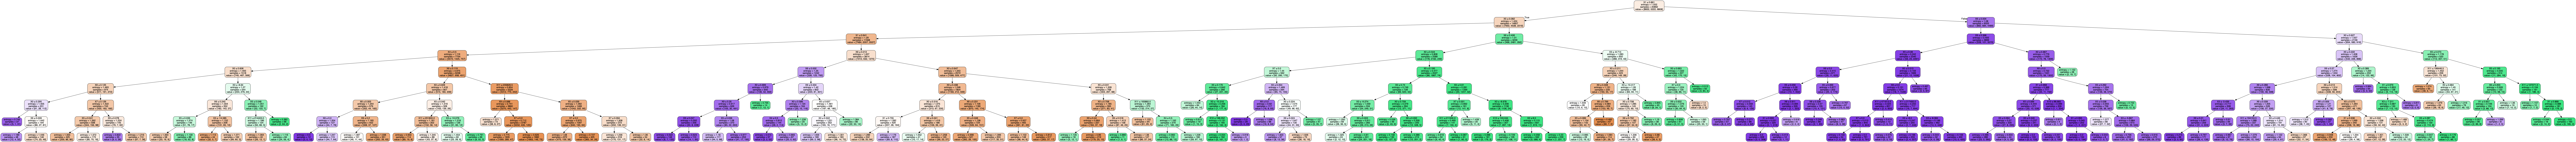

In [109]:
# Visualize the tree structure
dot_data = StringIO()

export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

By adding some parameters, we were able to increase our accuracy score by about 8%! This is a wonderful achievement towards optimizing our decision tree.

We can use this decision tree classifier to create a bagging classifier. Let's see how one performs on our data.

In [24]:
# Use our decision tree classifier to create an ensemble, draw 0.8 samples from X to train each estimator
bag = BaggingClassifier(dtc, n_estimators=100, max_samples=0.8, random_state=42)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=11, max_leaf_nodes=150, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=None, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [25]:
bag.score(X_test, y_test)

0.7864892070238229

Using the bagging classifier with our decision tree classifier, we were able to increase our score by 2%, just under 80%!

Let's test those songs from Part I on our sound based model. To get the audio features of the songs, we will have to use the Spotipy package. Below, we will use my Spotify account to authorize usage of this package.

In [26]:
client_credentials_manager = SpotifyClientCredentials(client_id='client credentials go here',
                                                      client_secret='client secret goes here')

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Once we are authorized, we are able to retrieve the song data.

In [27]:
# Create a dataframe that will hold the audio features of the three test songs
testsongsdf = pd.DataFrame(data=None, columns=X_test.columns, index=None)
songs = ['paul mccartney band on the run', 'drake hotline bling', 'title fight symmetry']

colnames = ['track', 'artist', 'genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
totalcount = 0

# This for-loop will search for each song and extract its audio features using Spotipy package
for s in songs:
    results = sp.search(s)
    try:
        track_id = results['tracks']['items'][0]['id']
        
        # Use track_id to find audio features of song
        features = sp.audio_features(tracks = [track_id])
        danceability = features[0]['danceability']
        energy = features[0]['energy']
        key = features[0]['key']
        loudness = features[0]['loudness']
        mode = features[0]['mode']
        speechiness = features[0]['speechiness']
        acousticness = features[0]['acousticness']
        instrumentalness = features[0]['instrumentalness']
        liveness = features[0]['liveness']
        valence = features[0]['valence']
        tempo = features[0]['tempo']
        duration_ms = features[0]['duration_ms']
        time_signature = features[0]['time_signature']
        
        cols = [danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, time_signature]
        testsongsdf.loc[totalcount] = cols
        totalcount += 1
    except:
        pass

print('Done,', totalcount, 'songs added.')

testsongsdf

Done, 3 songs added.


danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.479   0.601  7.0    -8.806   1.0       0.0318      0.083200   
1         0.903   0.621  2.0    -8.132   1.0       0.0578      0.003020   
2         0.430   0.967  6.0    -6.053   1.0       0.1050      0.000004   

   instrumentalness  liveness  valence    tempo  duration_ms  time_signature  
0          0.001420    0.1100    0.669  124.966     313027.0             4.0  
1          0.000186    0.0504    0.553  134.969     267067.0             4.0  
2          0.004510    0.2060    0.510   94.950     134293.0             4.0

Now that we have the audio features of our test songs, let's see how our model performs.

In [28]:
for i in range(3):
    print(songs[i], "=", bag.predict(testsongsdf)[i], "\n")

paul mccartney band on the run = country/folk/rock 

drake hotline bling = hip hop 

title fight symmetry = punk/metal 



We can see above that our sound based model has predicted each of the songs' genres correctly!